In [127]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [128]:
############## Import Libraries ##############################
import xgboost as xgb  # XGBoost, a powerful gradient boosting library
from sklearn.model_selection import GridSearchCV, train_test_split  # GridSearchCV for hyperparameter tuning, train_test_split for data splitting
from sklearn.svm import SVC  # Support Vector Classifier for SVM implementation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Metrics for model evaluation
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifier
from sklearn.linear_model import LogisticRegression  # Logistic Regression Classifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression  # Feature selection methods
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler  # Data preprocessing tools
from scipy.stats.mstats import winsorize  # Winsorize method for outlier handling
from scipy.stats import zscore, skew  # Z-score and skewness for statistical analysis
#from sklearn.pipeline import Pipeline  # Pipeline for chaining multiple steps
from matplotlib import pyplot as plt  # Matplotlib for plotting
from xgboost import XGBClassifier  # XGBoost classifier
from sklearn.impute import SimpleImputer  # Handle missing values
from sklearn.compose import ColumnTransformer  # Composite transformers for feature engineering
import seaborn as sns  # Seaborn for data visualization

In [129]:
path = str("/kaggle/input/spaceship-titanic/")
train_data = pd.read_csv(f"{path}train.csv")
test_data = pd.read_csv(f"{path}test.csv")
submission_data = pd.read_csv(f"{path}sample_submission.csv")

**Check Missing Values**

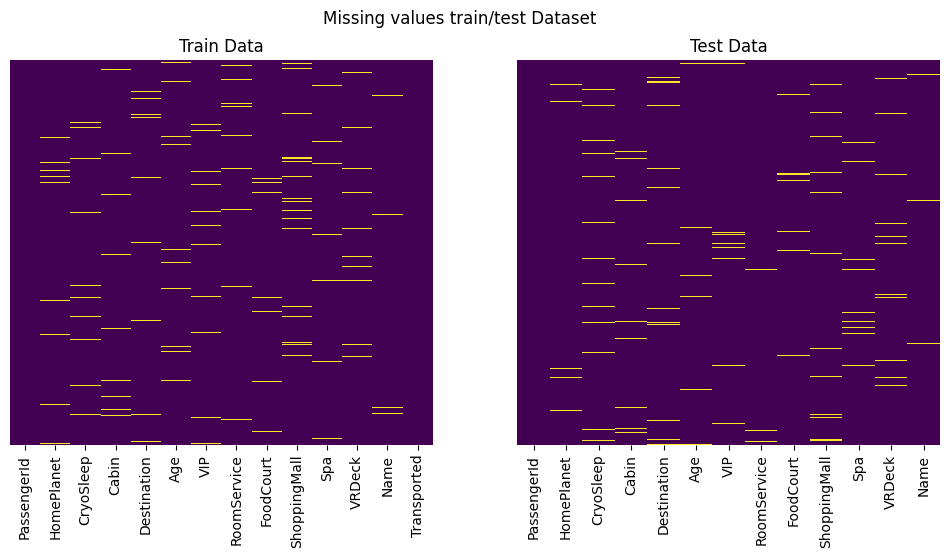

In [130]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.suptitle('Missing values train/test Dataset')

#Training data
sns.heatmap(train_data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis', ax=axes[0])
axes[0].set_title('Train Data')

#Test data
sns.heatmap(test_data.isnull(), yticklabels = False, cbar = False, cmap = 'viridis', ax=axes[1])
axes[1].set_title('Test Data')

plt.show()

**We have missing values in both provided test and train datasets. We will need to treat them. but first let us do some analysis - "Is there any relationship of missing values with certain feature values?"**

**Check Expense columns against CryoSleep as Passengers who are at cryosleep must not be making expenses**

> Class for plotting MIssing data analysis

In [131]:
class PlotsForMissingValues:
    expense_features = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    
    def __init__(self, df):
        self.df = df
        
    def list_missing(self):
        print("    Missing values    ")
        print("------------------------")
        print(self.df.isnull().sum())
        print("------------------------")
        print("------------------------")
        
    def BarPlot_cryosleep(self):
        #############
        for feature in self.expense_features:
            plt.figure(figsize=(2, 2))
            sns.barplot(x='CryoSleep', y=feature, data=self.df)
            plt.title("Train data : Bar Plot of " + feature + " wrt CryoSleep")
            plt.show()

    #selected_features = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    def PairPlot_CryVSExp(self):
        ###
        sns.pairplot(self.df[self.expense_features + ['CryoSleep']], hue='CryoSleep')
        plt.suptitle('Train Data : Pair Plot of Selected Features by CryoSleep', y=1.02)
        plt.show()

    def Cross_tab(self):
        # Create a new binary column indicating whether CryoSleep is True
        self.df['CryoSleep_True'] = self.df['CryoSleep'] == 'True'

        # Create a cross-tabulation for each expense feature
        for expense_feature in self.expense_features:
            cross_tab = pd.crosstab(self.df['CryoSleep_True'], self.df[expense_feature].isnull())

            # Visualize the cross-tabulation using a heatmap
            plt.figure(figsize=(2, 3))
            sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Train Data : Cross-tabulation of CryoSleep_True and {expense_feature} null values')
            plt.show()

> Plot between expense featuresand cryosleep. To check if all missing data in expense features is for the pssengers who are in cryosleep 

**Train data Plots**

    Missing values    
------------------------
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
------------------------
------------------------


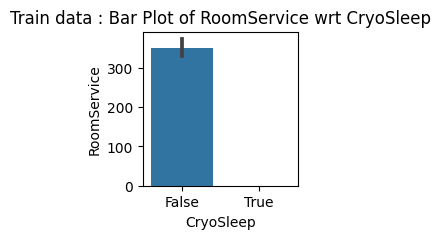

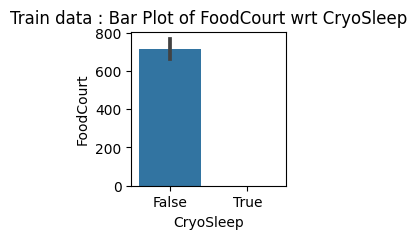

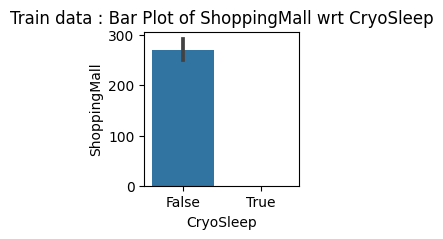

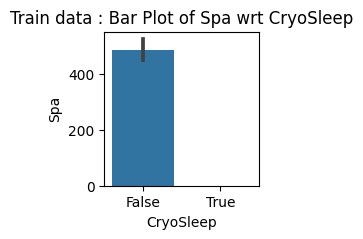

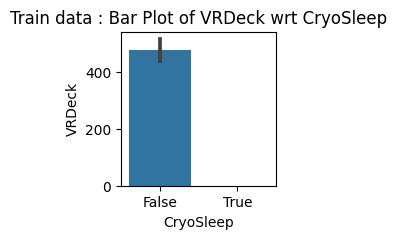

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

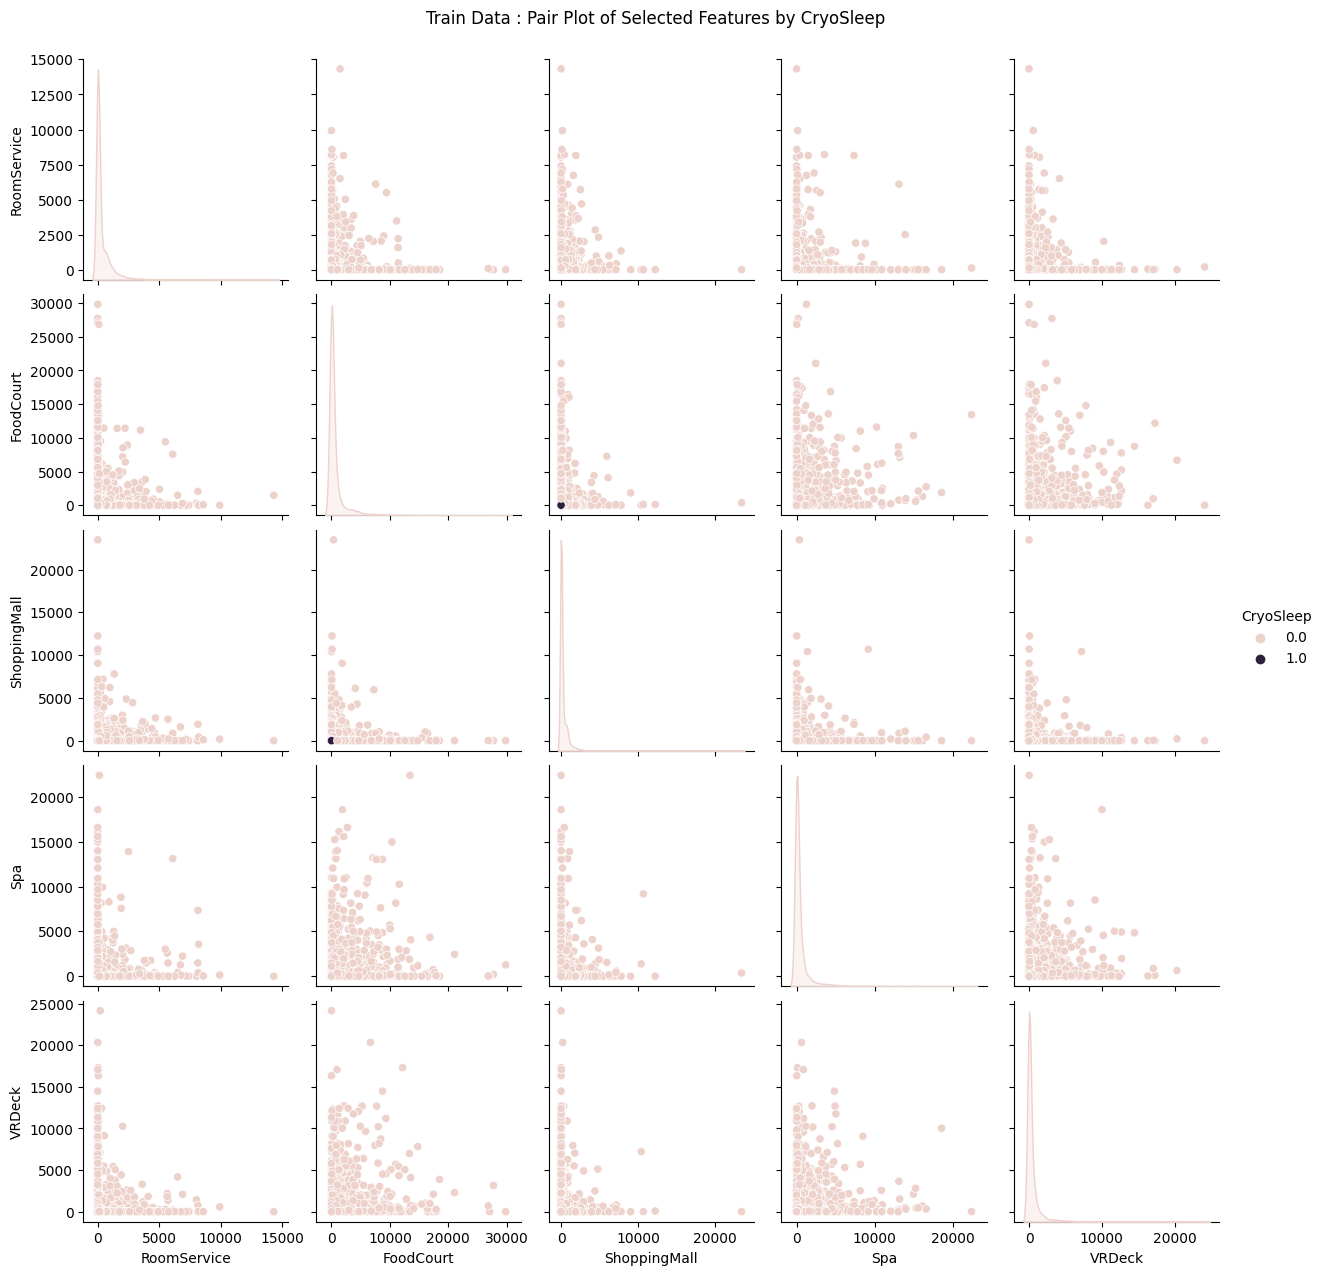

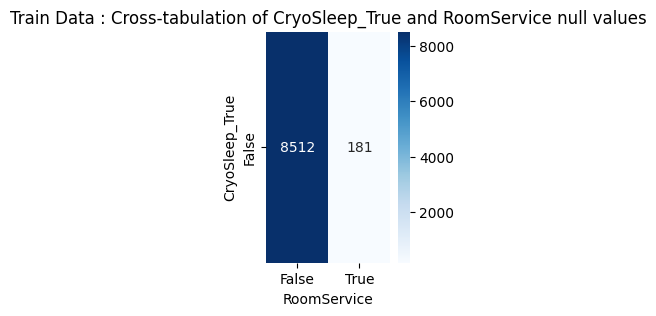

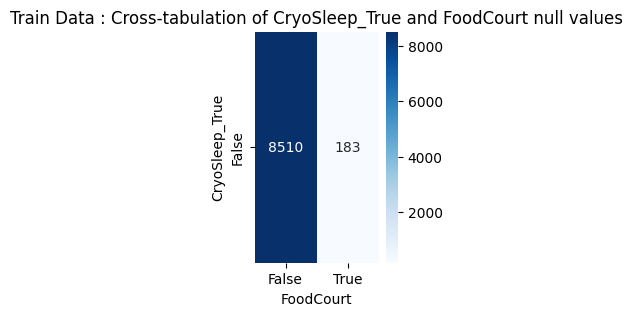

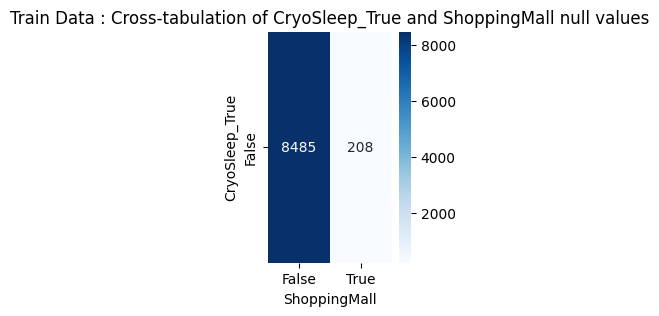

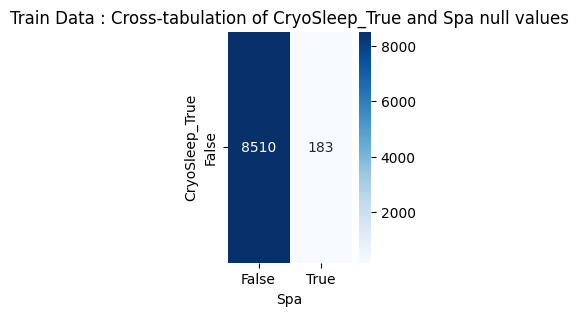

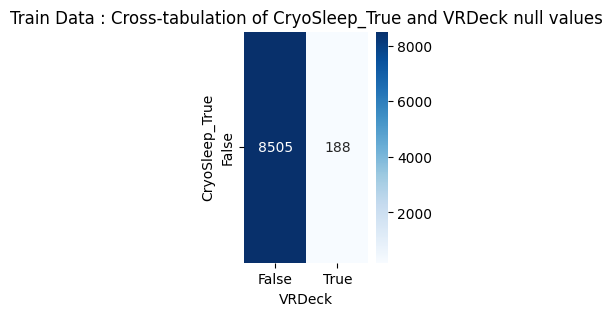

In [132]:
###############Initialize class object for train data###############################
missplot = PlotsForMissingValues(train_data)

##############Train data - List Missing values################
missplot.list_missing()

##############Train data - Bar Plot of expense features against Cryosleep################
missplot.BarPlot_cryosleep()

#####################Train data - Pair Plot of all expense features against CryoSleep##########
missplot.PairPlot_CryVSExp()

################Train data - Cross tabulation of expense columns against  CryoSleep################
missplot.Cross_tab()

**Test Data Plots: To check if we observe same pattern**

    Missing values    
------------------------
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64
------------------------
------------------------


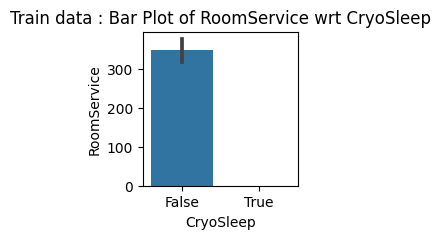

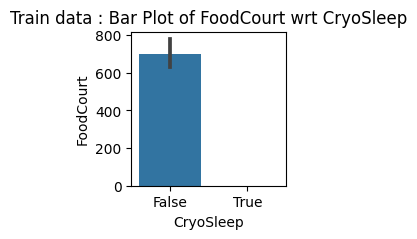

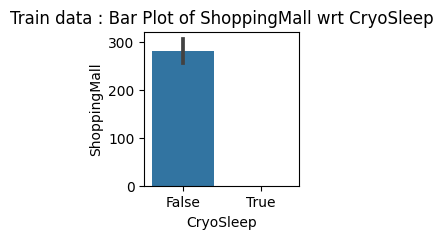

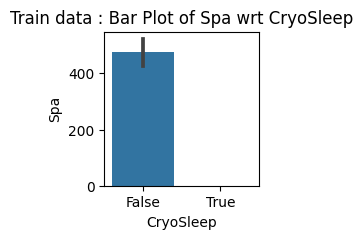

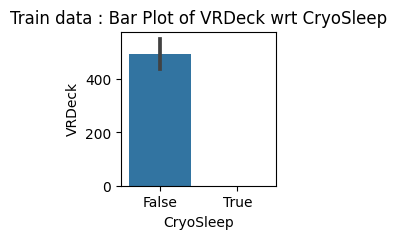

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

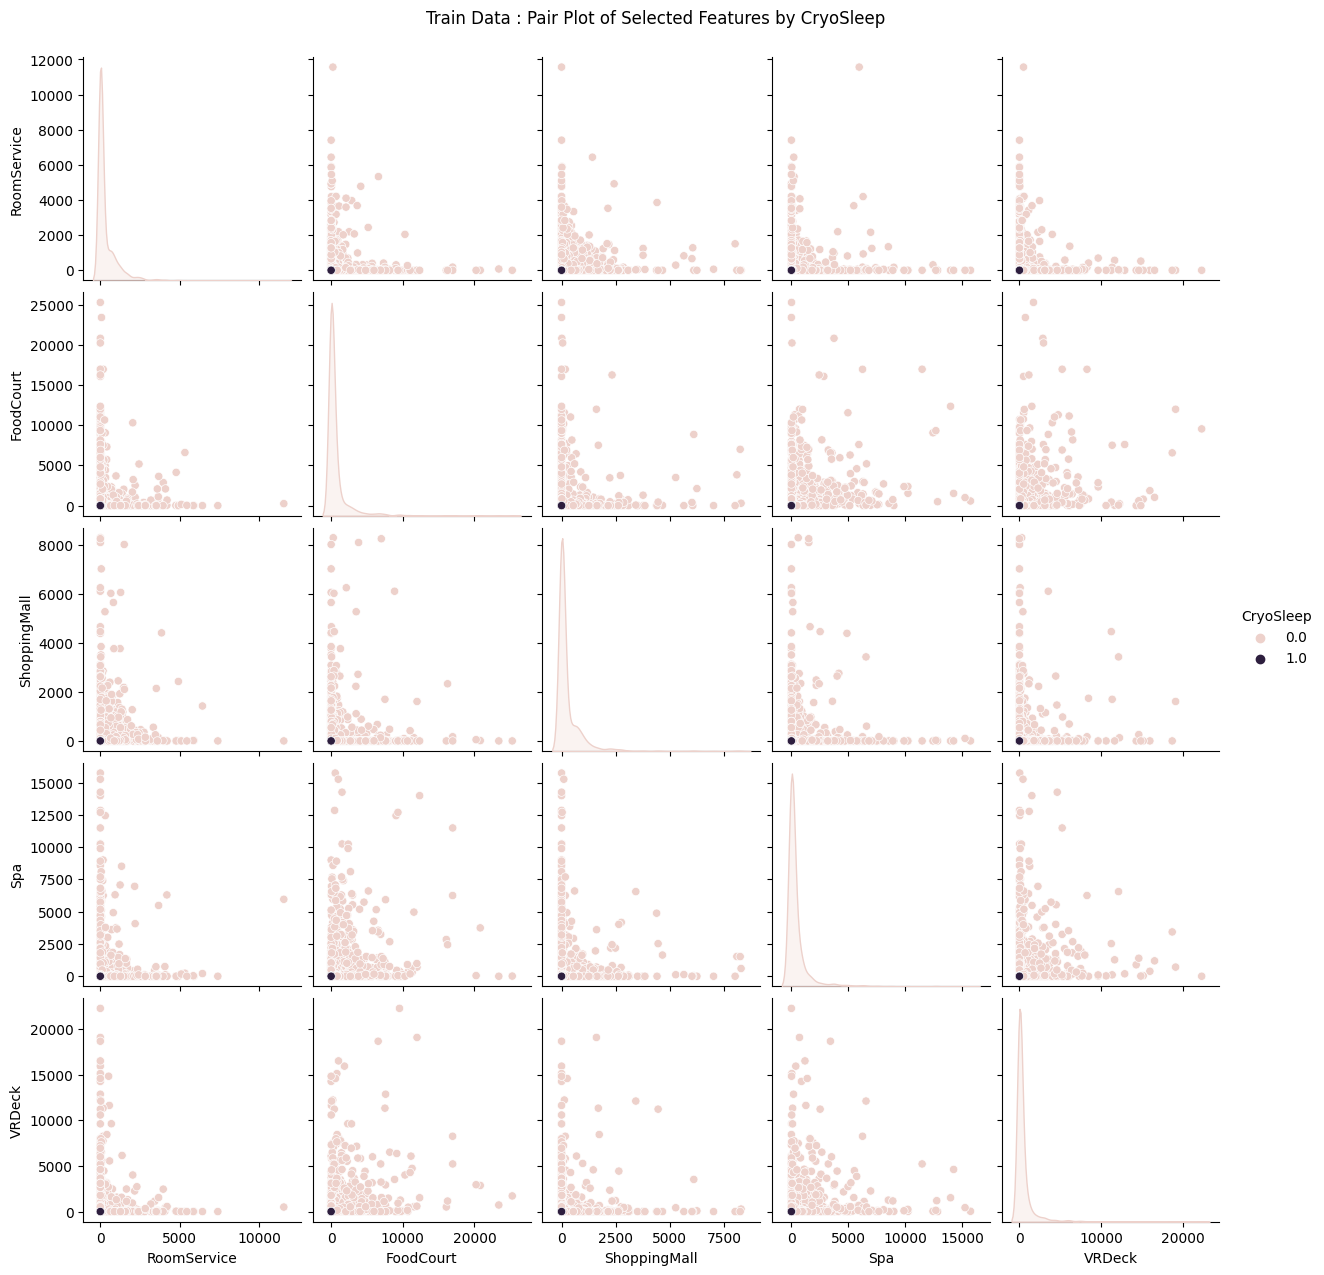

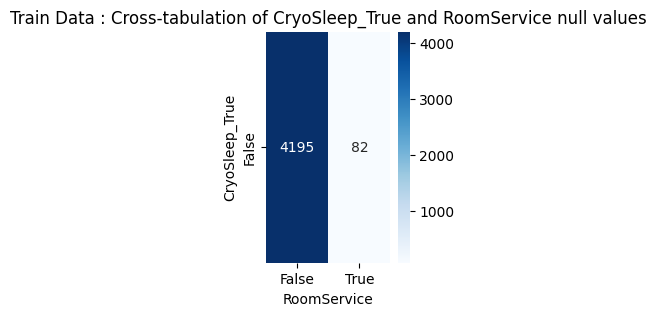

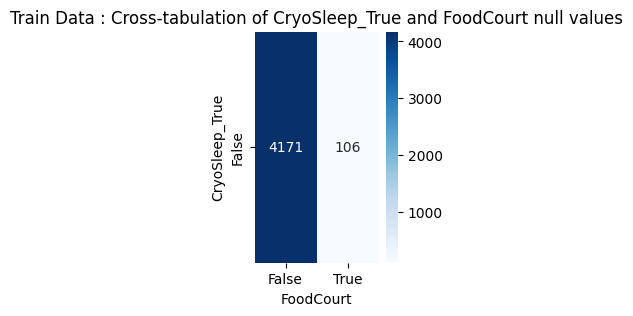

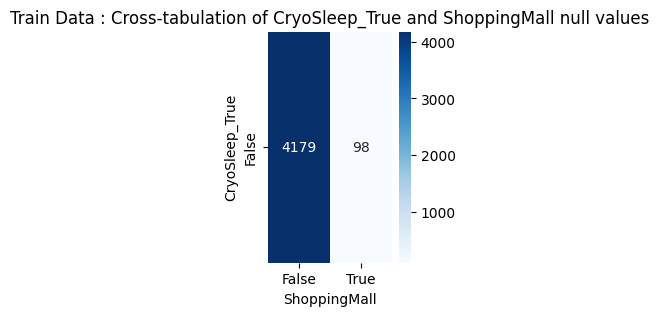

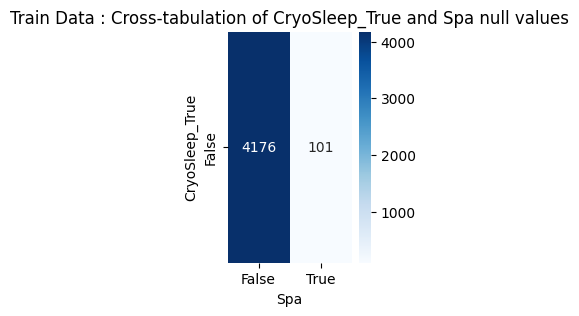

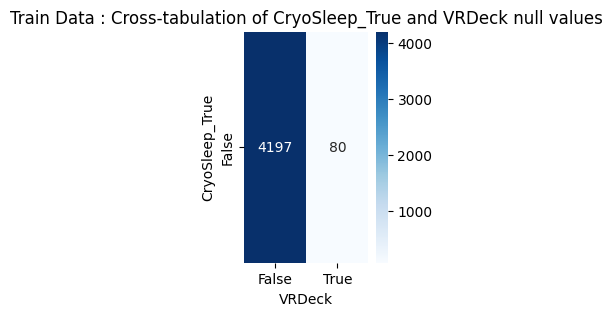

In [133]:
###############Initialize class object for test data###############################
missplot = PlotsForMissingValues(test_data)

##############Test Data - List missing values#########################
missplot.list_missing()

##############Train data - Bar Plot of expense features against Cryosleep################
missplot.BarPlot_cryosleep()

#####################Train data - Pair Plot of all expense features against CryoSleep##########
missplot.PairPlot_CryVSExp()

################Train data - Cross tabulation of expense columns against  CryoSleep################
missplot.Cross_tab()

**Yes, Above observation is right**
* We can see above that both train and test data shows same pattern for missing values in Expenses columns and Cryosleep True values
* No Expenses are there for the passengers who were in cryosleep so they are reflected as missing in data available

**Missing Value Treatment**
* As all missing values in expenses are for cryosleep passengers. Replacing with 0.
* As Age is distributed mostly around 10-40, Replace missing values in Age with median
* Categorical features available are ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin','Destination', 'VIP','Name'] Let us ignore PassengerID as no missing, Ignore Cabin and Name as well and replace all other with most frequent values.

In [134]:
###########################Function to treat missing values ##############################
def treat_missing(df):
    # Impute missing values for all categorical features with the most frequent category
    categorical_columns = df.select_dtypes(include='object').columns
     #categorical_columns = categorical_columns.pop(['Cabin', 'Name'])
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])
    
    # Replace missing values with 0 for all expense features
    expense_features = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df[expense_features] = df[expense_features].fillna(0)
    
    #Replace missing value in Age with Median age
    df['Age'].fillna(df['Age'].median(), inplace=True)
    return df

In [135]:
###Treat missing in train data
train_data = treat_missing(train_data)

###Treat missing in test data
test_data = treat_missing(test_data)

print("Missing in Train data ")
print(train_data.isnull().sum())

print("Missing in Test data ")
print(test_data.isnull().sum())

Missing in Train data 
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
Transported       0
CryoSleep_True    0
dtype: int64
Missing in Test data 
PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name              0
CryoSleep_True    0
dtype: int64


/tmp/ipykernel_34/511842149.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipykernel_34/511842149.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

## **Data Visualization**

**Let us examine various plots**

In [136]:
################## Function to Plot simple plots ####################3
def simple_plots(df):
    ######

    fig, axes = plt.subplots(2, 3, figsize=(12, 5))
    #plt.suptitle('')

    sns.countplot(x='Transported', data = df, ax=axes[0,0])
    #axes[0,0].set_title('Transported CountPlot')

    sns.countplot(x='Transported', hue = 'HomePlanet', data = df, ax=axes[0,1])
    #axes[0,1].set_title('Transported vs HomePlanet')

    sns.countplot(x='HomePlanet', data = df, ax=axes[0,2])
    #axes[0,2].set_title('HomePlanet countPlot')

    sns.countplot(x='Transported', hue = 'CryoSleep', data = df, ax=axes[1,0])
    #axes[1,0].set_title('Transported vs CryoSleep')

    sns.countplot(x='Transported', hue = 'Destination', data = df, ax=axes[1,1])
    #axes[1,1].set_title('Transported vs Destination')

    sns.countplot(x='Transported', hue = 'VIP', data = df, ax=axes[1,2])
    #axes[1,2].set_title('Transported vs VIP')

    plt.tight_layout()
    plt.show()

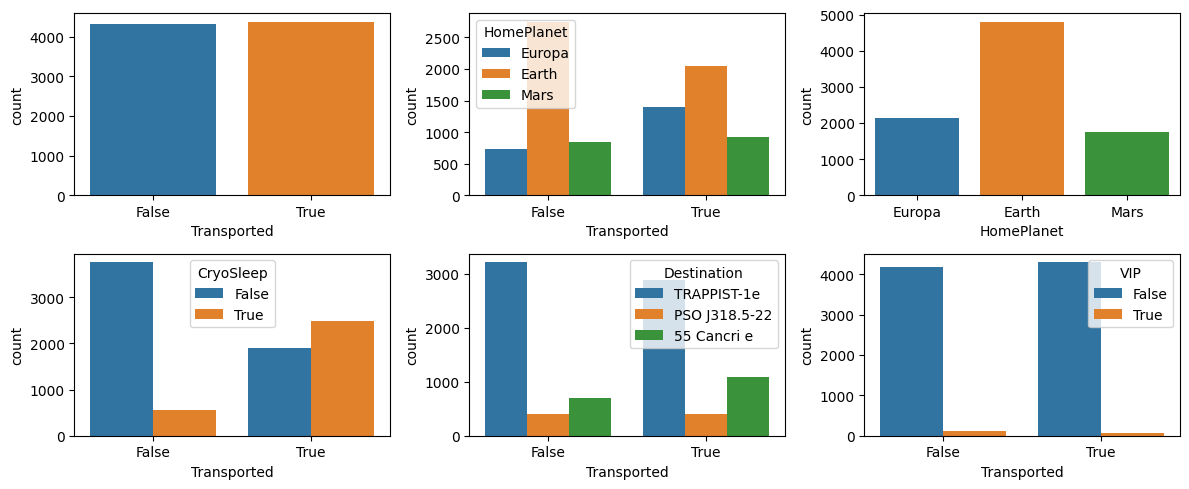

In [137]:
simple_plots(train_data)

**Analysis from Plots**
* Transported counts for both category seems quite equal
* Most travellers were from Earth then from Europa and then Mars
* So, Most number of transported and not transported passengers are both from Earth but we can see Compares to Europa, People from Mars were not transported mostly
* Mostly Passengers which were not in CryoSleep were not transported
* Destination vs Transported does not show pretty much difference. Have similar behaviour in both cases
* Only few VIPs were there and not much difference in count bars

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


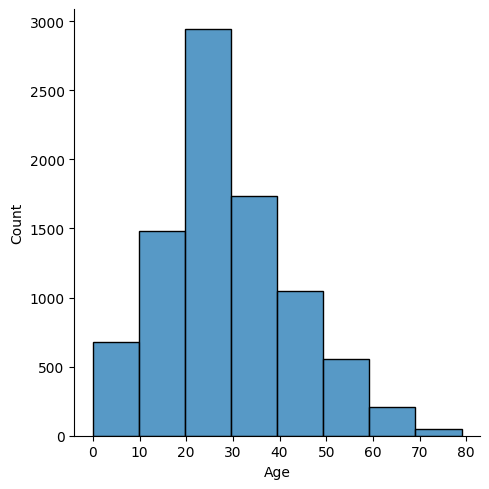

In [138]:
sns.displot(train_data['Age'],bins = 8)

***
***Mostly passenger travelling are between 10-40***
***

In [139]:
######## Taking too much time - commenting #########
##sns.catplot(x='Transported', y='RoomService', data=train_data, kind='swarm', palette='Set2')

***
### Plotting to understand Relationship between Transported and Expense features, Transported feature
***

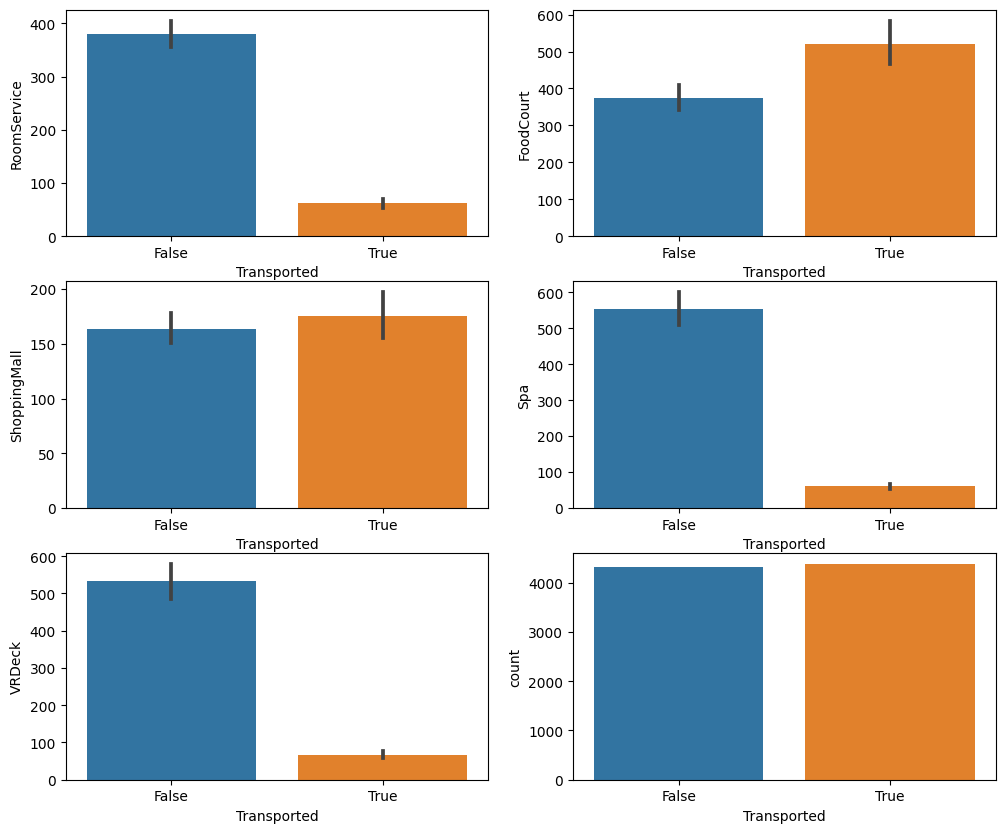

In [140]:
fig, axes = plt.subplots(3, 2, figsize=(12,10 ))
#plt.suptitle('')

sns.barplot(x='Transported', y='RoomService', data=train_data, ax=axes[0,0])

sns.barplot(x='Transported', y='FoodCourt', data=train_data, ax=axes[0,1])

sns.barplot(x='Transported', y='ShoppingMall', data=train_data, ax=axes[1,0])

sns.barplot(x='Transported', y='Spa', data=train_data, ax=axes[1,1])

sns.barplot(x='Transported', y='VRDeck', data=train_data, ax=axes[2,0])

sns.countplot(x='Transported', data = train_data, ax=axes[2,1])

plt.show()

***
* Only Features FoodCourt & ShoppingMall have wider expenses for transported passengers. We need to check why? 
* For rest all expense features, Passengers who made high expenses are less in transported category.
* Count of passengers Transported and not transported is almost at equal. Slightly More Transported count.
***

* Age:
<p> The median age of passengers who were transported and those who were not transported appears to be similar.
There are some outliers in the age of transported passengers.</p>

* RoomService:
<p>Passengers who were not transported tend to have a wider range of room service usage.
There are outliers in room service usage for both transported and non-transported passengers.</p>

* FoodCourt:
<p>Transported passengers have a wider distribution of expenses at the food court compared to non-transported passengers.
There are outliers in food court expenses for both groups.</p>

* ShoppingMall:
<p>Passengers who were transported have a wider range of expenses at the shopping mall.
There are outliers in shopping mall expenses for both groups.</p>

* Spa:
<p>Expenses at the spa are generally higher for transported passengers, with a wider distribution.
There are outliers in spa expenses for both groups.</p>

* VRDeck:
<p>Passengers who were transported tend to have a wider range of expenses at the VR deck.
There are outliers in VR deck expenses for both groups.</p>

**Plotting to understand distribution of data, Outliers etc.**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


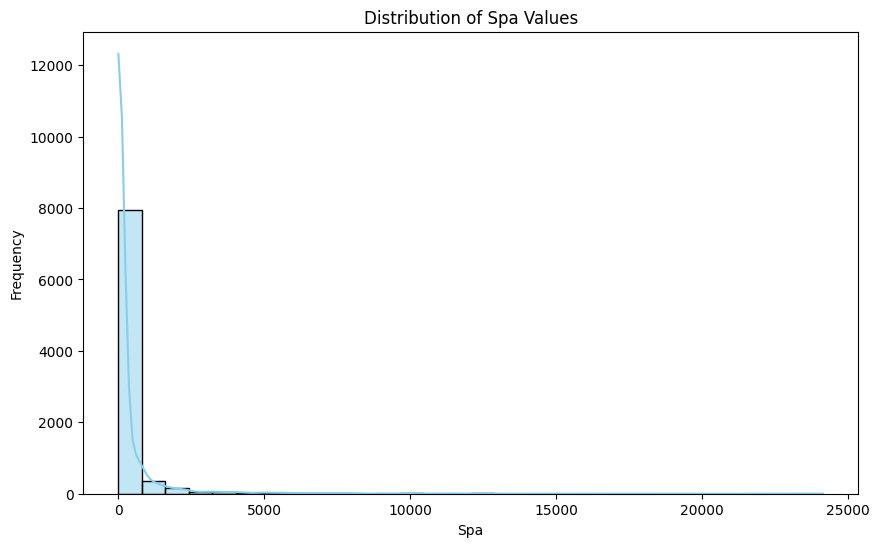

In [141]:
# Drawing a bar plot for the 'Spa' column
plt.figure(figsize=(10, 6))
sns.histplot(train_data['VRDeck'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Spa Values')
plt.xlabel('Spa')
plt.ylabel('Frequency')
plt.show()

PLotting districutions shows skewness in data

In [142]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'CryoSleep_True'],
      dtype='object')

In [143]:
##################################Skewness in train data################

skewness_Age = skew(train_data['Age'])
skewness_RoomService = skew(train_data['RoomService'])
skewness_FoodCourt = skew(train_data['FoodCourt'])
skewness_ShoppingMall = skew(train_data['ShoppingMall'])
skewness_Spa = skew(train_data['Spa'])
skewness_VRDeck = skew(train_data['VRDeck'])
print(f"\tTrain Data : Skewness in differnt features")
print(f"Age : {skewness_Age}")
print(f"RoomService : {skewness_RoomService}")
print(f"FoodCourt : {skewness_FoodCourt}")
print(f"ShoppingMall : {skewness_ShoppingMall}")
print(f"Spa : {skewness_Spa}")
print(f"VRDeck : {skewness_VRDeck}")

	Train Data : Skewness in differnt features
Age : 0.4310279653704558
RoomService : 6.396661848251665
FoodCourt : 7.176276632484426
ShoppingMall : 12.761639609477124
Spa : 7.715118060862281
VRDeck : 7.9031903980797065


In [144]:
##################################Skewness in test data################
#from scipy.stats import skew
skewness_Age = skew(test_data['Age'])
skewness_RoomService = skew(test_data['RoomService'])
skewness_FoodCourt = skew(test_data['FoodCourt'])
skewness_ShoppingMall = skew(test_data['ShoppingMall'])
skewness_Spa = skew(test_data['Spa'])
skewness_VRDeck = skew(test_data['VRDeck'])
print(f"\tTest Data : Skewness in differnt features")
print(f"Age : {skewness_Age}")
print(f"RoomService : {skewness_RoomService}")
print(f"FoodCourt : {skewness_FoodCourt}")
print(f"ShoppingMall : {skewness_ShoppingMall}")
print(f"Spa : {skewness_Spa}")
print(f"VRDeck : {skewness_VRDeck}")

	Test Data : Skewness in differnt features
Age : 0.5012646700340578
RoomService : 5.609480657471784
FoodCourt : 6.994925985828178
ShoppingMall : 6.8995899443361965
Spa : 7.778651923262596
VRDeck : 8.462827235328836


Age and all expense features have right skewness in both train and test data. We will need to transform data.
* Skewness = 0: The distribution is perfectly symmetric.
* Skewness > 0: Right-skewed.
* Skewness < 0: Left-skewed.

In [145]:
#sns.displot(df['ShoppingMall'],kde = True, bins = 20)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


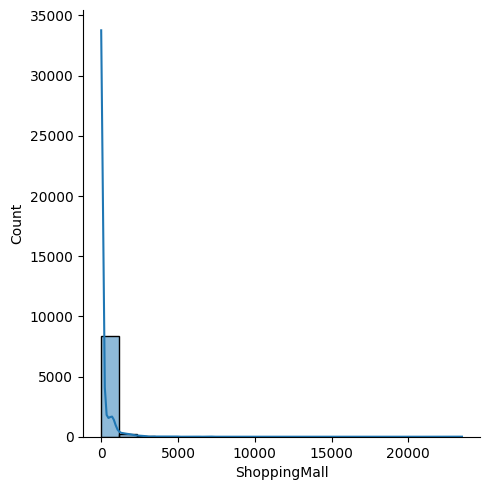

In [146]:
sns.displot(train_data['ShoppingMall'],kde = True, bins = 20)

In [147]:
Q1 = train_data['Age'].quantile(0.25)
Q3 = train_data['Age'].quantile(0.75)
IQR = Q3 - Q1
outliers = (train_data['Age'] < Q1 - 1.5 * IQR) | (train_data['Age'] > Q3 + 1.5 * IQR)
print(f"    IQR : Outliers in Age = {outliers.sum()}")

    IQR : Outliers in Age = 162


In [148]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.790291,220.009318,448.434027,169.572300,304.588865,298.261820
std,14.341404,660.519050,1595.790627,598.007164,1125.562559,1134.126417
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [149]:
########### Function to detect outliers ###############
def detect_outliers(df):
    features = ['Age', 'RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    outliers = 0
    
    for feature in features:
        #### IQR test #######
        print(feature)
        outlliers = 0
       
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outliers = (df[feature] < Q1 - 1.5 * IQR) | (df[feature] > Q3 + 1.5 * IQR)
        print(f"    IQR : Outliers in {feature} = {outliers.sum()}")

In [150]:
########### Trying to detect outliers ###############
print("\n\tOutliers in Train Data")
detect_outliers(train_data)

print("\n\tOutliers in Test Data")
detect_outliers(test_data)



	Outliers in Train Data
Age
    IQR : Outliers in Age = 162
RoomService
    IQR : Outliers in RoomService = 1906
FoodCourt
    IQR : Outliers in FoodCourt = 1916
ShoppingMall
    IQR : Outliers in ShoppingMall = 1879
Spa
    IQR : Outliers in Spa = 1833
VRDeck
    IQR : Outliers in VRDeck = 1849

	Outliers in Test Data
Age
    IQR : Outliers in Age = 75
RoomService
    IQR : Outliers in RoomService = 919
FoodCourt
    IQR : Outliers in FoodCourt = 931
ShoppingMall
    IQR : Outliers in ShoppingMall = 912
Spa
    IQR : Outliers in Spa = 921
VRDeck
    IQR : Outliers in VRDeck = 927


In [151]:
print(train_data.describe())
expense_features = ['RoomService','FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
count=0
for feature in expense_features:
    avg = train_data[feature].mean()
    count = 0
    for i in train_data[feature]:
        if i < avg:
            count +=1
    print("Values analysis for ",feature)
    print("Below Average =",count)
    print("Above Average =",(train_data[feature].count() - count))

               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8693.000000   8693.000000   8693.000000   8693.000000   8693.000000   
mean     28.790291    220.009318    448.434027    169.572300    304.588865   
std      14.341404    660.519050   1595.790627    598.007164   1125.562559   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      20.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      37.000000     41.000000     61.000000     22.000000     53.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8693.000000  
mean     298.261820  
std     1134.126417  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       40.000000  
max    24133.000000  
Values analysis for  RoomService
Below Average = 7078
Above Average = 1615
Values analysis for  Foo

**Check Outliers of expense features against VIP - Check possibility that outliers might be high expenses made by VIPs**

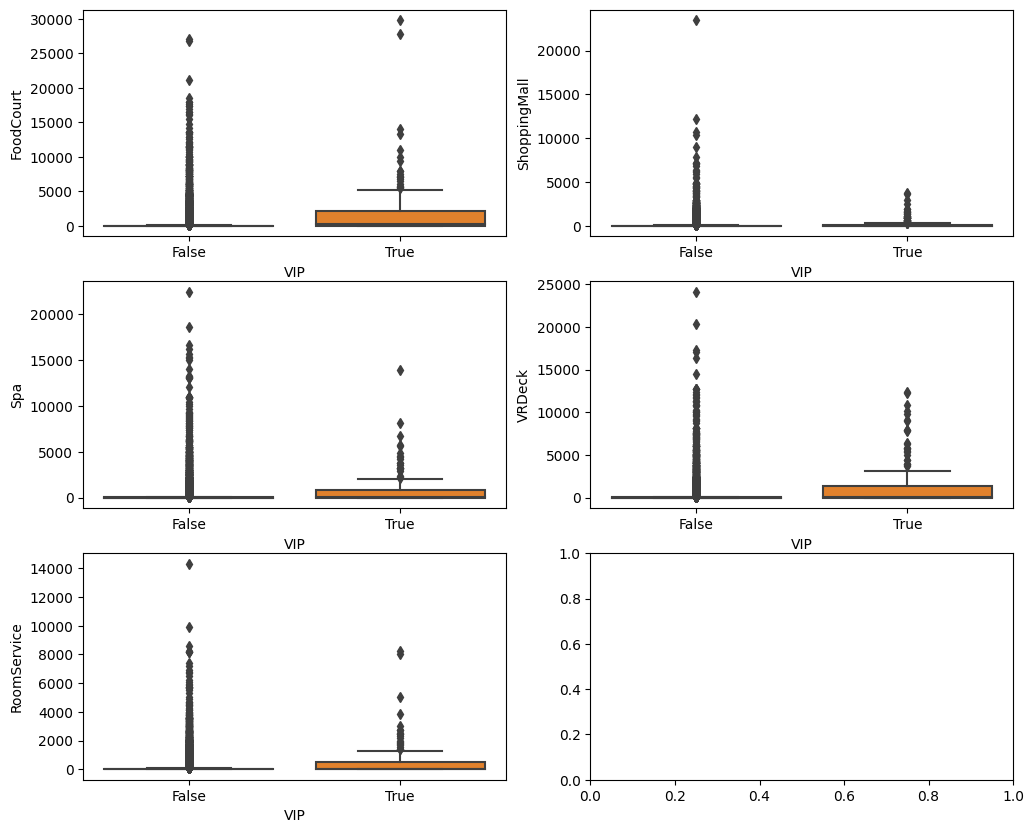

<Figure size 400x600 with 0 Axes>

In [152]:
################ Box Plot for Expenses #######################

fig, axes = plt.subplots(3, 2, figsize=(12,10 ))

#expenses_data = train_data[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']]
plt.figure(figsize=(4, 6))
sns.boxplot(x = 'VIP', y= 'FoodCourt' , data=train_data, ax=axes[0,0])
sns.boxplot(x = 'VIP', y= 'ShoppingMall' , data=train_data, ax=axes[0,1])
sns.boxplot(x = 'VIP', y= 'Spa' , data=train_data, ax=axes[1,0])
sns.boxplot(x = 'VIP', y= 'VRDeck' , data=train_data, ax=axes[1,1])
sns.boxplot(x = 'VIP', y= 'RoomService' , data=train_data, ax=axes[2,0])
plt.show()

**It is clear that Outliers are really outliers**

### **Winsorize method to remove outliers**

Remove outliers in train data

In [153]:
train_data['Spa'] = winsorize(train_data['Spa'], limits=[0.05, 0.05])
train_data['FoodCourt'] = winsorize(train_data['FoodCourt'], limits=[0.05, 0.05])
train_data['ShoppingMall'] = winsorize(train_data['ShoppingMall'], limits=[0.05, 0.05])
train_data['VRDeck'] = winsorize(train_data['VRDeck'], limits=[0.05, 0.05])
train_data['RoomService'] = winsorize(train_data['RoomService'], limits=[0.05, 0.05])

Remove outliers in test data

In [154]:
test_data['Spa'] = winsorize(test_data['Spa'], limits=[0.05, 0.05])
test_data['FoodCourt'] = winsorize(test_data['FoodCourt'], limits=[0.05, 0.05])
test_data['ShoppingMall'] = winsorize(test_data['ShoppingMall'], limits=[0.05, 0.05])
test_data['VRDeck'] = winsorize(test_data['VRDeck'], limits=[0.05, 0.05])
test_data['RoomService'] = winsorize(test_data['RoomService'], limits=[0.05, 0.05])

In [155]:
#sns.displot(train_data['ShoppingMall'],kde = True, bins = 20)

In [156]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported', 'CryoSleep_True'],
      dtype='object')

<Axes: ylabel='count'>

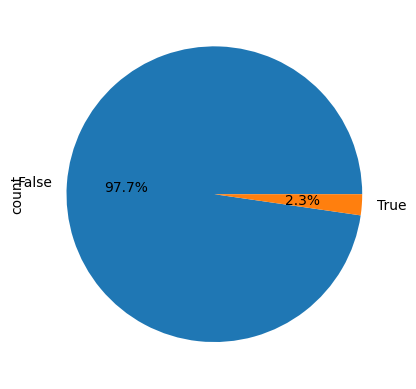

In [157]:
#fig, axes = plt.subplots(3, 2, figsize=(12,10 ))

#expenses_data = train_data[['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService']]
#plt.figure(figsize=(4, 6))
#sns.boxplot(x = 'VIP', y= 'FoodCourt' , data=train_data, ax=axes[0,0])
# Pie Chart for VIP Status
train_data['VIP'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='count'>

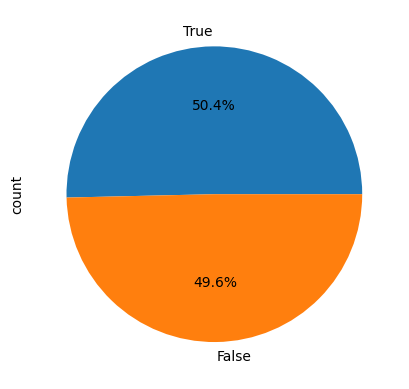

In [158]:
train_data['Transported'].value_counts().plot.pie(autopct='%1.1f%%')


<Axes: ylabel='count'>

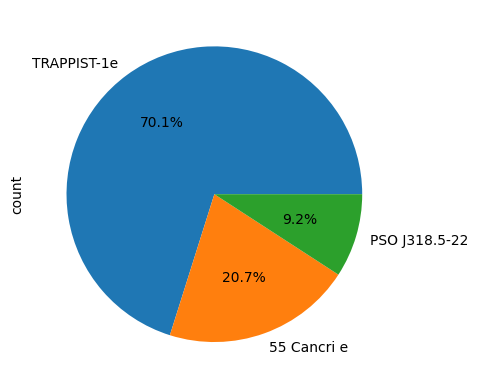

In [159]:
train_data['Destination'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='count'>

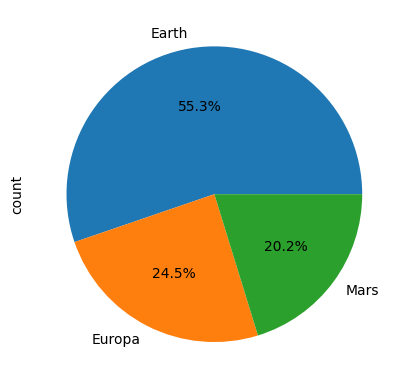

In [160]:
train_data['HomePlanet'].value_counts().plot.pie(autopct='%1.1f%%')

<Axes: ylabel='count'>

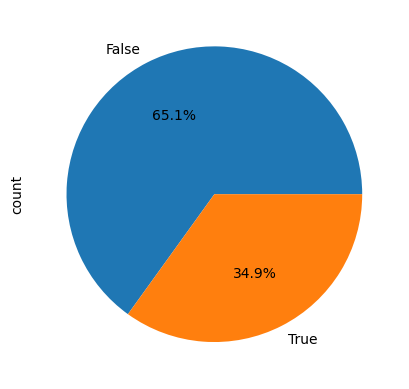

In [161]:
train_data['CryoSleep'].value_counts().plot.pie(autopct='%1.1f%%')

**Drop unnnecessary columns**

In [162]:
########### Drop from train data #################
# 
columns_to_drop = ['Cabin', 'PassengerId', 'Name']

# Drop specified columns
train_data.drop(columns=columns_to_drop, inplace=True)


In [163]:
########### Drop from test data #################
# Save passengerID for later use
pass_id = test_data['PassengerId'].copy()
columns_to_drop = ['Cabin', 'PassengerId', 'Name']

# Drop specified columns
test_data.drop(columns=columns_to_drop, inplace=True)


In [164]:
print(f"Features in train_data \n{train_data.columns}")
print(f"Features in test_data \n{test_data.columns}")

Features in train_data 
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'CryoSleep_True'],
      dtype='object')
Features in test_data 
Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep_True'],
      dtype='object')


**Change categorical to numeric**

In [165]:
##################### Train data ##########################



categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical columns to numerical
for column in categorical_columns:
    train_data[column] = label_encoder.fit_transform(train_data[column])

# Convert 'Transported' column to numerical (True=1, False=0)
train_data['Transported'] = train_data['Transported'].astype(int)


In [166]:
##################### Test data ##########################



categorical_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert categorical columns to numerical
for column in categorical_columns:
    test_data[column] = label_encoder.fit_transform(test_data[column])

# Convert 'Transported' column to numerical (True=1, False=0)
#train_data['Transported'] = train_data['Transported'].astype(int)


In [167]:
print("Train data\n")
print(train_data.head())
print("\nTest data\n")
print(test_data.head())

Train data

   HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0           1          0            2  39.0    0          0.0        0.0   
1           0          0            2  24.0    0        109.0        9.0   
2           1          0            2  58.0    1         43.0     2670.0   
3           1          0            2  33.0    0          0.0     1283.0   
4           0          0            2  16.0    0        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  CryoSleep_True  
0           0.0     0.0     0.0            0           False  
1          25.0   549.0    44.0            1           False  
2           0.0  1580.0    49.0            0           False  
3         371.0  1580.0   193.0            0           False  
4         151.0   565.0     2.0            1           False  

Test data

   HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  FoodCourt  \
0           0          1            2  27.0    0          0.0    

In [168]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HomePlanet      8693 non-null   int64  
 1   CryoSleep       8693 non-null   int64  
 2   Destination     8693 non-null   int64  
 3   Age             8693 non-null   float64
 4   VIP             8693 non-null   int64  
 5   RoomService     8693 non-null   float64
 6   FoodCourt       8693 non-null   float64
 7   ShoppingMall    8693 non-null   float64
 8   Spa             8693 non-null   float64
 9   VRDeck          8693 non-null   float64
 10  Transported     8693 non-null   int64  
 11  CryoSleep_True  8693 non-null   bool   
dtypes: bool(1), float64(6), int64(5)
memory usage: 755.7 KB


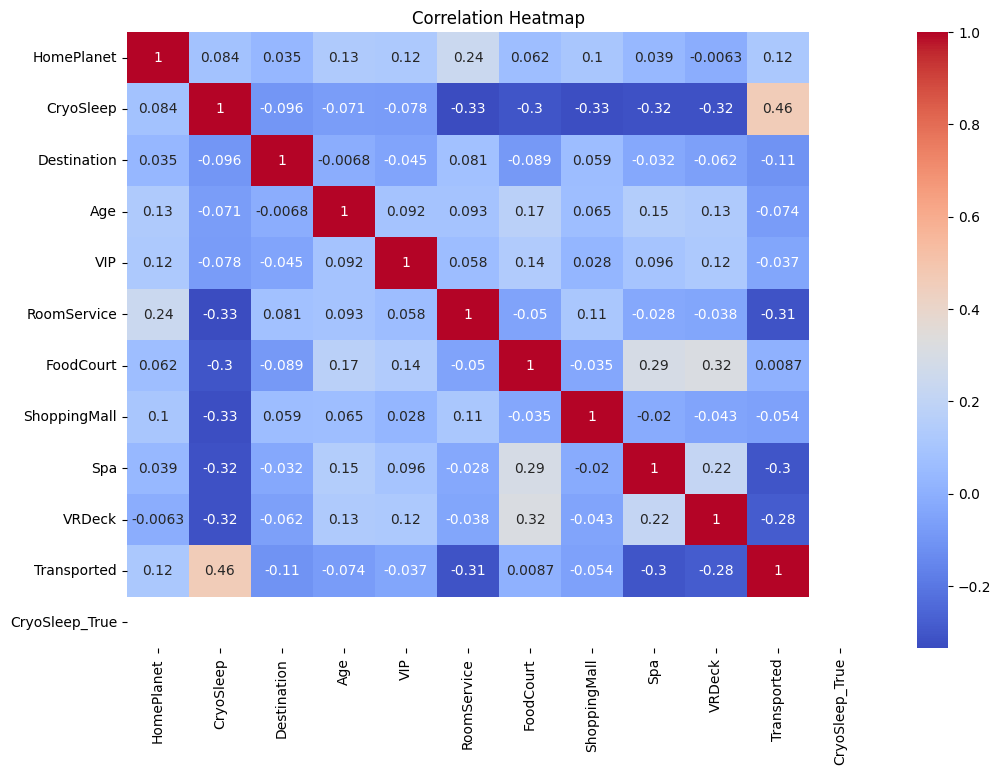

In [169]:
# Correlation heatmap train data
corr_matrix = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

> Expense Features are highly negatively correlated with CryoSleep

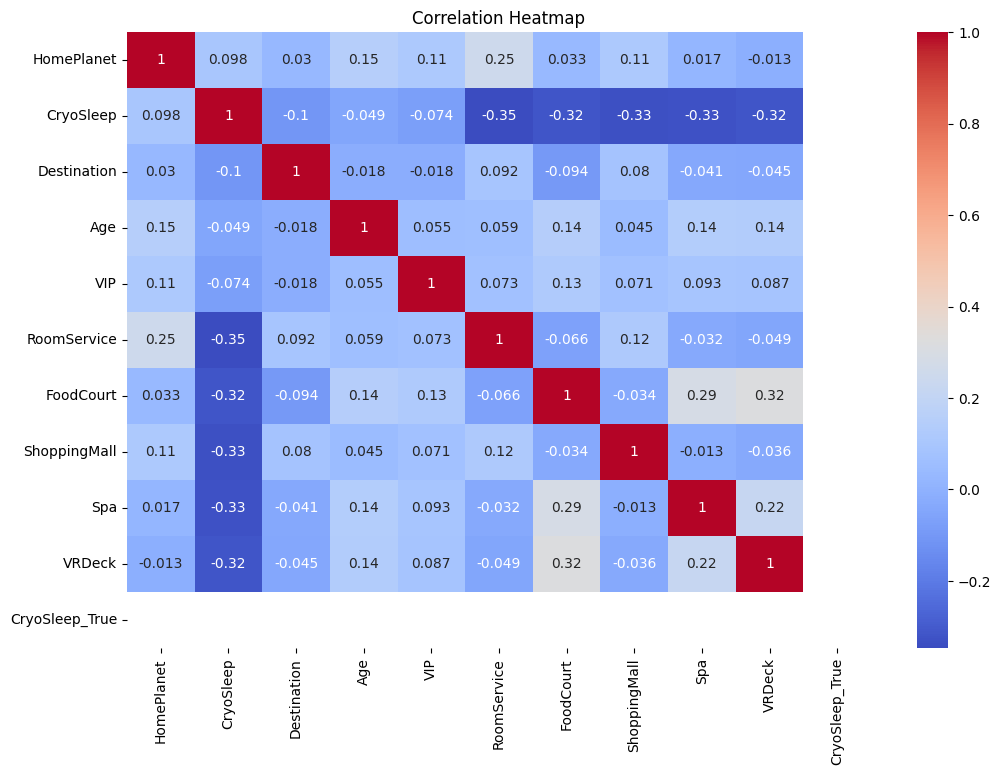

In [170]:
# Correlation heatmap
corr_matrix = test_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

> Similar to train data the correlation matrix is same for test data

In [171]:

correlation_matrix = train_data.corr()

# Extract the correlation of each feature with 'Transported'
correlation_with_transported = correlation_matrix['Transported']

# Sort the correlation values in descending order
sorted_correlation = correlation_with_transported.abs().sort_values(ascending=False)

# Print the sorted correlation values
print(sorted_correlation)

Transported       1.000000
CryoSleep         0.460132
RoomService       0.308443
Spa               0.303459
VRDeck            0.282353
HomePlanet        0.115461
Destination       0.108152
Age               0.074233
ShoppingMall      0.053648
VIP               0.037261
FoodCourt         0.008704
CryoSleep_True         NaN
Name: Transported, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

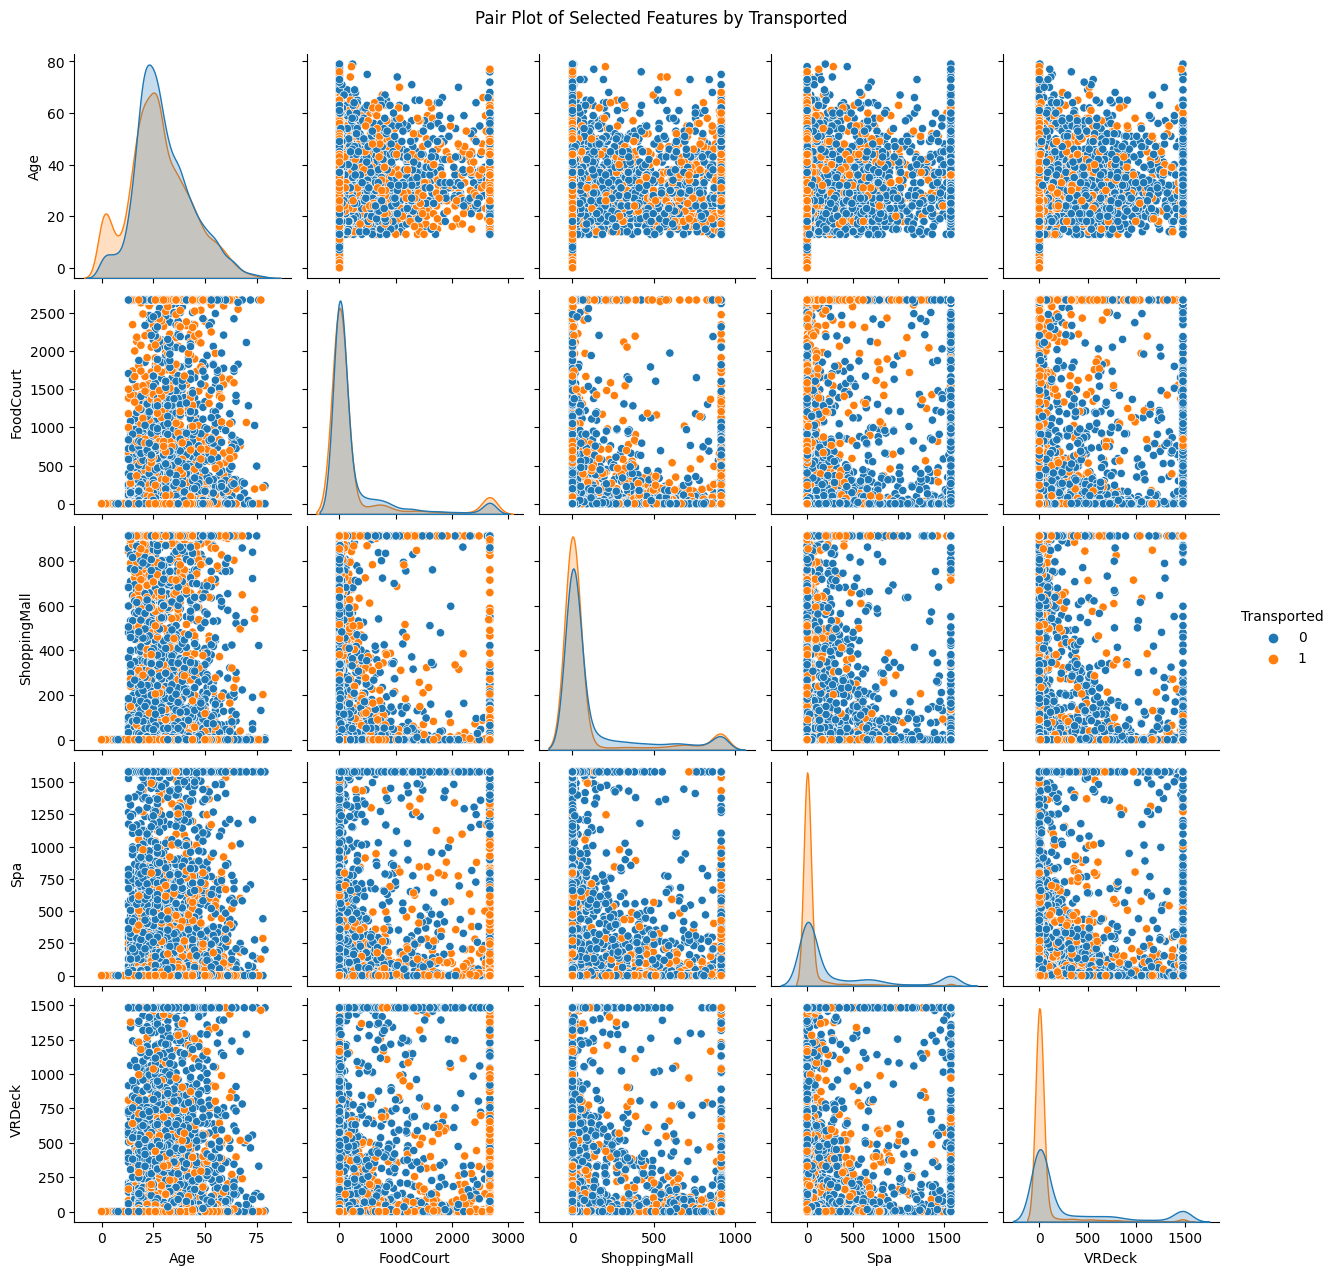

In [172]:
####This I Need to interprete after thourough research on pair plots
#Pair plot for selected features
selected_features = ['Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
sns.pairplot(train_data[selected_features + ['Transported']], hue='Transported')
plt.suptitle('Pair Plot of Selected Features by Transported', y=1.02)
plt.show()

**Check Impact of Age on Transported**

In [173]:
#sns.scatterplot(x='Age',  y='Transported', hue='Transported',data=train_data)
#plt.title('Scatterplot between Age and Transported')
#plt.xlabel('Age')
#plt.ylabel('Transported')
#plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 78.4% of the points cannot be placed; you may want to decrease the size of the mar

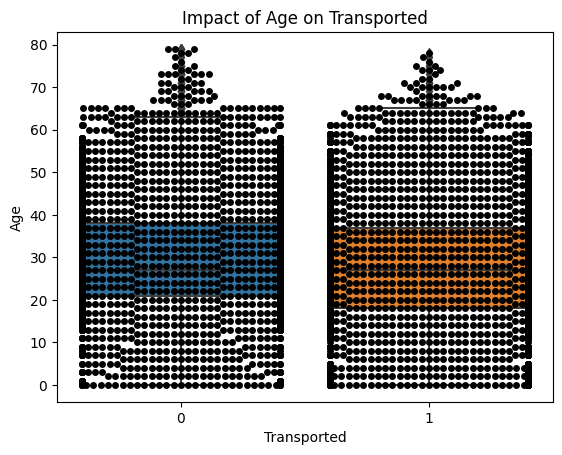

In [174]:
sns.boxplot(x='Transported', y='Age', data=train_data)
sns.swarmplot(x='Transported', y='Age', data=train_data, color='black')  # Add swarm plot for individual data points
plt.title('Impact of Age on Transported')
plt.xlabel('Transported')
plt.ylabel('Age')
plt.show()

Seems no impact of Age on Transported

Data Cleaning:

Handle missing values.
Convert categorical variables to appropriate data types.
Univariate Analysis:

Explore the distribution of each variable individually.
Bivariate Analysis:

Analyze relationships between independent variables and the target variable.
Feature Selection:

Identify important features that contribute significantly to the prediction of the target variable.
Correlation Analysis:

Explore correlations between variables, especially with the target variable.

In [175]:
# Bivariate Analysis - Boxplots
#plt.figure(figsize=(15, 8))
#for i, column in enumerate(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']):
#    plt.subplot(2, 3, i+1)
#    sns.boxplot(x='Transported', y=column, data=train_data)
#    plt.title(column)
#plt.tight_layout()
#plt.show()

### Feature Selection using ANOVA F-statistic

In [176]:
X = train_data.drop('Transported', axis=1)
y = train_data['Transported']
selector = SelectKBest(f_classif, k='all')
selector.fit(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
feature_scores.sort_values(by='Score', ascending=False, inplace=True)


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [177]:
feature_scores

,Feature,Score
1,CryoSleep,2334.295199
5,RoomService,913.767980
8,Spa,881.505486
9,VRDeck,752.897119
0,HomePlanet,117.427316
2,Destination,102.861127
3,Age,48.156922
7,ShoppingMall,25.086302
4,VIP,12.083096
6,FoodCourt,0.658512


| Feature       | Correlation |
|---------------|-------------|
| Transported   | 1.000000    |
| CryoSleep     | 0.460132    |
| RoomService   | 0.308443    |
| Spa           | 0.303459    |
| VRDeck        | 0.282353    |
| HomePlanet    | 0.115461    |
| Destination   | 0.108152    |
| Age           | 0.074233    |
| ShoppingMall  | 0.053648    |
| VIP           | 0.037261    |
| FoodCourt     | 0.008704    |


In [178]:
selected_features = ['CryoSleep', 'RoomService','Spa', 'VRDeck', 'HomePlanet', 'Destination']


**Simple Logistic Regression Model**

In [ ]:
# Features and target variable
X = train_data[selected_features]
y = train_data['Transported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr_model.predict(X_test_scaled)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [190]:
print(f"Logistic Regression Score : {lr_model.score(X_test, y_test)}")

NameError: name 'lr_model' is not defined

In [180]:
train_data.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported',
       'CryoSleep_True'],
      dtype='object')

### **Applying Different Advanced Approach**

#### **GridSearCV with RandomForestClassifier**

In [181]:
selected_features = ['CryoSleep', 'RoomService','Spa', 'VRDeck', 'HomePlanet', 'Destination', 'Age', 'ShoppingMall', 'VIP', 'FoodCourt']
#selected_features = ['CryoSleep', 'RoomService','Spa', 'VRDeck', 'HomePlanet', 'Destination']

X = train_data[selected_features]
y = train_data['Transported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create GridSearchCV instance
rf_grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)

# Fit the model
rf_grid_search.fit(X_train, y_train)

# Get the best parameters
#best_params = grid_search.best_params_

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [182]:
# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", rf_grid_search.best_params_)
print("Best Accuracy: {:.4f}".format(rf_grid_search.best_score_))

# Evaluate the model on the test set
test_accuracy = rf_grid_search.score(X_test, y_test)
print("Test Accuracy: {:.4f}".format(test_accuracy))

Best Hyperparameters:  {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Best Accuracy: 0.7995
Test Accuracy: 0.7832


#### **GridSearchCV with XGBoost**

In [183]:
selected_features = ['CryoSleep', 'RoomService','Spa', 'VRDeck', 'HomePlanet', 'Destination', 'Age', 'ShoppingMall', 'VIP', 'FoodCourt']
#selected_features = ['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'HomePlanet', 'Destination']

X = train_data[selected_features]
y = train_data['Transported']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create the XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Create GridSearchCV instance
xgb_grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5)

# Fit the model
xgb_grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = xgb_grid_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Make predictions on the test set
y_pred = xgb_grid_search.predict(X_test)

# Evaluate the model (you can use various metrics depending on your problem)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Accuracy: 0.7849338700402531


In [184]:
# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters: ", xgb_grid_search.best_params_)
print("Best Accuracy: {:.4f}".format(xgb_grid_search.best_score_))

# Evaluate the model on the test set
test_accuracy = xgb_grid_search.score(X_test, y_test)
print("Test Accuracy: {:.4f}".format(test_accuracy))

Best Hyperparameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
Best Accuracy: 0.7972
Test Accuracy: 0.7849


**GridSearCV with SVC**

**Below one is taking longer so commenting. Will try someday later**

In [185]:
# Assuming 'train_data' is your DataFrame
#selected_features = ['CryoSleep', 'RoomService', 'Spa', 'VRDeck', 'HomePlanet', 'Destination', 'Age', 'ShoppingMall', 'VIP', 'FoodCourt']

#X = train_data[selected_features]
#y = train_data['Transported']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for SVC
#svc_param_grid = {
#    'C': [0.1, 1, 10],
#    'kernel': ['linear', 'rbf', 'poly'],
#    'gamma': ['scale', 'auto']
#}

# Create the Support Vector Classifier (SVC)
#svc_classifier = SVC()

# Create GridSearchCV instance for SVC
#svc_grid_search = GridSearchCV(estimator=svc_classifier, param_grid=svc_param_grid, cv=5)

# Fit the SVC model
#svc_grid_search.fit(X_train, y_train)

# Get the best parameters for SVC
#best_params_svc = svc_grid_search.best_params_

# Predictions on the test set
#y_pred_svc = svc_grid_search.predict(X_test)

# Print accuracy and classification report for SVC
#print(f"Best Parameters for SVC: {best_params_svc}")
#print(f"Accuracy for SVC: {accuracy_score(y_test, y_pred_svc)}")
#print("Classification Report for SVC:\n", classification_report(y_test, y_pred_svc))


### **Make Final Predictions**

In [193]:
predictions = xgb_grid_search.predict(test_data[selected_features])
print(predictions)

[1 0 1 ... 1 1 1]


In [194]:
predict_bool = []
for i in predictions:
    if i == 1:
        predict_bool.append(True)
    else:
        predict_bool.append(False)

In [188]:
submission_data["Transported"] = predict_bool
submission_data.head()

In [195]:
submission_data.to_csv('submission.csv', index=False)